In [1]:
import random
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt
import warnings
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

random.seed(30)
df = pd.read_csv("data/us_change.csv", index_col=0)
df

,Quarter,Consumption,Income,Production,Savings,Unemployment
1,1970 Q1,0.618566,1.044801,-2.452486,5.299014,0.9
2,1970 Q2,0.451984,1.225647,-0.551459,7.789894,0.5
3,1970 Q3,0.872872,1.585154,-0.358652,7.403984,0.5
4,1970 Q4,-0.271848,-0.239545,-2.185691,1.169898,0.7
5,1971 Q1,1.901345,1.975925,1.909764,3.535667,-0.1
...,...,...,...,...,...,...
194,2018 Q2,0.983112,0.661825,1.117424,-2.723974,0.0
195,2018 Q3,0.853181,0.806271,1.256722,-0.085686,-0.3
196,2018 Q4,0.356512,0.695142,0.948148,5.031337,0.2
197,2019 Q1,0.282885,1.100753,-0.488206,9.760287,-0.1


Nesse notebook, iremos explorar modelos SARIMA e SARIMAX, ou seja, inicialmente desconsiderando variáveis exogenas e depois considerando.


In [2]:
def convert_to_period(quarter):
    """
    Function to convert a string to a pandas period object. 
    Checks if the input is a string in the form '2019 Q1' or already a Period.
    """
    if isinstance(quarter, pd.Period):
        return quarter
    year, quarter_str = quarter.split()
    year = int(year)
    quarter = int(quarter_str[-1])
    return pd.Period(year=year, quarter=quarter, freq='Q')

df['Quarter'] = df['Quarter'].apply(convert_to_period)

In [3]:
def mean_absolute_scaled_error(y_true, y_pred, y_train):
    """
    Função para calcular o MASE (Mean Absolute Scaled Error).
    """
    naive_forecast = np.roll(y_train, 1)[1:]  # Série atrasada para o erro naive
    mae_naive = mean_absolute_error(y_train[1:], naive_forecast)
    mae_model = mean_absolute_error(y_true, y_pred)
    return mae_model / mae_naive

df['Quarter'] = df['Quarter'].apply(lambda x: x.to_timestamp())
df.set_index("Quarter", inplace=True)

### SARIMA



MAE: 0.2752089925312631
RMSE: 0.3387040233389617
MASE: 0.45019220327285925


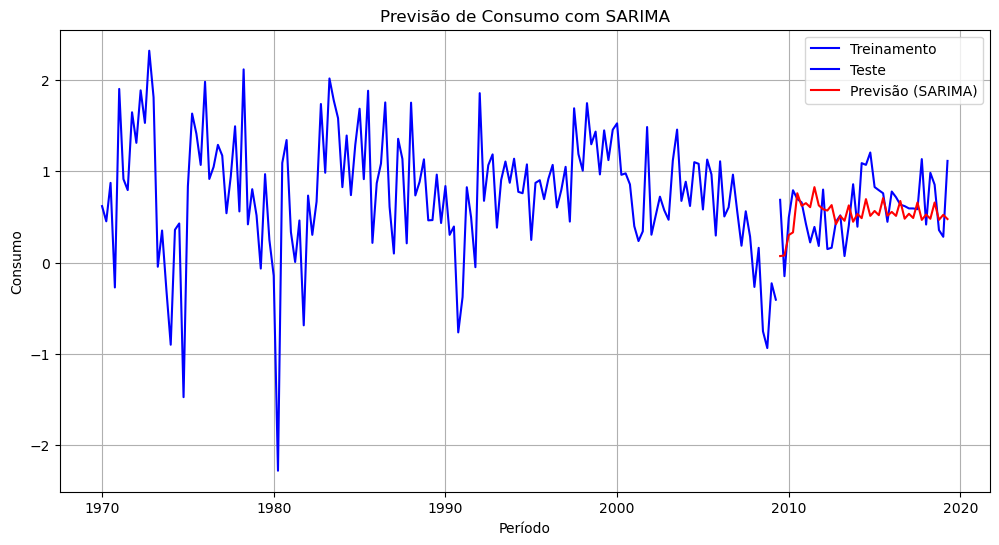

In [ ]:
# Dados originais
data = df.copy()
y = data['Consumption']

# Divisão em treino e teste
train_size = int(len(data) * 0.8)
y_train, y_test = y[:train_size], y[train_size:]

order = (3, 1, 3)  # Parâmetros (p, d, q)
seasonal_order = (4, 1, 1, 4)  # Parâmetros sazonais (P, D, Q, s)

model = SARIMAX(y_train, order=order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)

y_pred = model_fit.predict(start=len(y_train), end=len(y)-1)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MASE: {mean_absolute_scaled_error(y_test, y_pred, y_train)}')


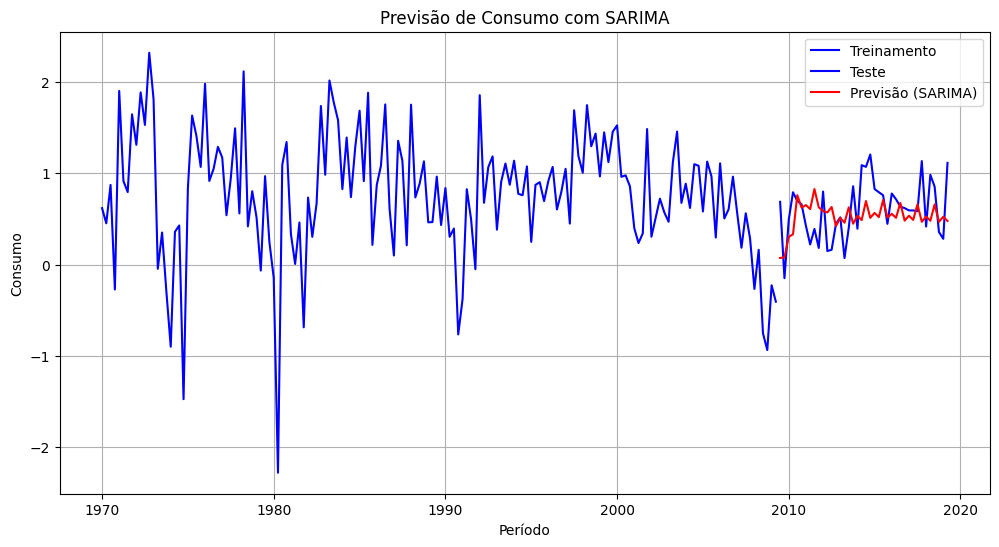

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train_original, label='Treinamento', color='blue')  # Use y_train_original no gráfico
plt.plot(y_test.index, y_test, label='Teste', color='blue')
plt.plot(y_test.index, y_pred, label='Previsão (SARIMA)', color='red')
plt.legend()
plt.title('Previsão de Consumo com SARIMA')
plt.xlabel('Período')
plt.ylabel('Consumo')
plt.grid()
plt.show()


### SARIMAX

MAE: 0.1167898169981938
RMSE: 0.15404947180174444
MASE: 0.19104704592193938


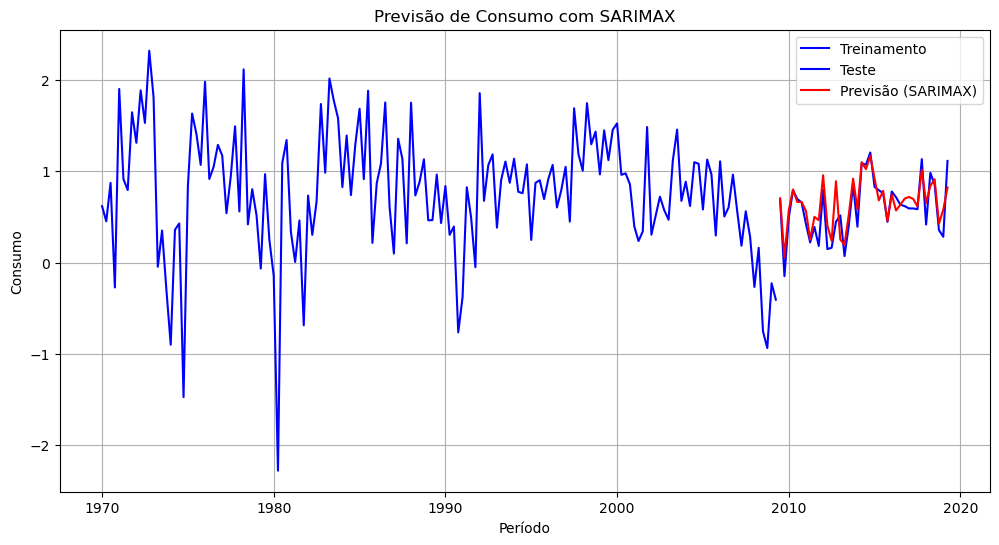

In [ ]:
# Dados originais
data = df.copy()

y = data['Consumption']
X = data[['Income', 'Unemployment', 'Savings', 'Production']]

# Divisão em treino e teste
train_size = int(len(data) * 0.8)
y_train, y_test = y[:train_size], y[train_size:]
X_train, X_test = X[:train_size], X[train_size:]


order = (1, 1, 3)  # Parâmetros (p, d, q)
seasonal_order = (1, 1, 1, 4)  # Parâmetros sazonais (P, D, Q, s)

# Definição dos parâmetros SARIMAX
order = (1, 1, 3)
seasonal_order = (1, 1, 1, 4)

# Ajuste do modelo SARIMAX
model = SARIMAX(y_train, exog=X_train, order=order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)

# Previsão
y_pred = model_fit.predict(start=len(y_train), end=len(y)-1, exog=X_test)

# Reverter escala se normalizado
if normalize:
    y_pred = pd.Series(
        scaler_y.inverse_transform(y_pred.to_numpy().reshape(-1, 1)).flatten(),
        index=y_test.index  # Preservar os índices
    )
    y_test = pd.Series(
        scaler_y.inverse_transform(y_test.to_numpy().reshape(-1, 1)).flatten(),
        index=y_test.index  # Preservar os índices
    )

# Implementação do MASE
def mean_absolute_scaled_error(y_true, y_pred, y_train):
    naive_forecast = np.roll(y_train, 1)[1:]  # Série atrasada para erro naive
    mae_naive = mean_absolute_error(y_train[1:], naive_forecast)
    mae_model = mean_absolute_error(y_true, y_pred)
    return mae_model / mae_naive

# Reverter escala de y_train para o cálculo do MASE, se necessário
if normalize:
    y_train_original = scaler_y.inverse_transform(y_train.to_numpy().reshape(-1, 1)).flatten()
else:
    y_train_original = y_train

mase = mean_absolute_scaled_error(y_test, y_pred, y_train_original)

# Avaliação
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Resultados
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MASE: {mase}")

# Visualização
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train_original, label='Treinamento', color='blue')  # Use y_train_original no gráfico
plt.plot(y_test.index, y_test, label='Teste', color='blue')
plt.plot(y_test.index, y_pred, label='Previsão (SARIMAX)', color='red')
plt.legend()
plt.title('Previsão de Consumo com SARIMAX')
plt.xlabel('Período')
plt.ylabel('Consumo')
plt.grid()
plt.show()
